<table width="100%" style="border:none">
  <tr>
    <td valign="top">
      <h1>GTEx RNAseq SABV Analysis</h1>
      <ul>
<li>Author: Jeremy Yang
<li>Based on R code by Oleg Ursu.
<li>Required: Python3, Pandas 0.22+
<li>Input reshaped, derived GTEx RNAseq expression data.
<li>Compute log fold-change per gene+tissue.
<li>Compute tissue specificity index (Yanai et al., 2004).
      </ul>
[About Colaboratory](https://research.google.com/colaboratory/faq.html).    
    </td>
    <td align="right">
        <p>NIH Data Commons: Team Helium</p>
<img style="float:right" width="100" src="https://avatars2.githubusercontent.com/u/33356654?s=200&v=4" alt="HeliumDataCommons Logo" />
    </td>
  </tr>
  </table>
 

In [32]:
import sys,os,re,time,io
import urllib.request
try:
    import google.colab
except:
    pass
import numpy,scipy,scipy.stats
import pandas as pd
print('Python: %s; Pandas: %s; Scipy: %s ; Numpy: %s'%(sys.version.split()[0],pd.__version__,scipy.__version__,numpy.__version__))

Python: 3.7.4; Pandas: 0.25.1; Scipy: 1.3.1 ; Numpy: 1.17.2


### Upload Median TPMs datafile:

In [2]:
try:
    tpms = pd.read_csv("gtex_rnaseq_prep_median.tsv", sep='\t')
except:
    try:
        print('Upload Median TPMs datafile: ')
        uploaded = google.colab.files.upload()
        fn = list(uploaded.keys())[0]
        print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
        tpms = pd.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t')
    except:
        print("Failed.")
print("dataset nrows: %d ; ncols: %d:"%(tpms.shape[0],tpms.shape[1]), file=sys.stderr)

dataset nrows: 4670 ; ncols: 4:


In [3]:
tpms.head()

,ENSG,SMTSD,SEX,TPM
0,ENSG00000008130.15,Adipose - Subcutaneous,female,63.265
1,ENSG00000008130.15,Adipose - Subcutaneous,male,53.590
2,ENSG00000008130.15,Adipose - Visceral (Omentum),female,58.310
3,ENSG00000008130.15,Adipose - Visceral (Omentum),male,51.745
4,ENSG00000008130.15,Adrenal Gland,female,67.880


### Read tissues files with groups

### Read and merge gene symbols.
File from https://www.ensembl.org/biomart, dataset human genes, fields Gene stable ID, Gene stable ID version,  NCBI gene ID, HGNC symbol.

In [4]:
try:
    genes = pd.read_csv("/home/data/GTEx/exfiles_data/biomart_ENSG2xrefs_human.tsv", sep='\t', usecols=[1,2,4], na_values=[''], dtype={2:str})
except Exception as e:
    print(e)
    try:
        print('Upload Biomart ENSG2NCBI genes datafile: ')
        uploaded = google.colab.files.upload()
        fn = list(uploaded.keys())[0]
        print('Uploaded "{name}" with {length} bytes'.format(name=fn, length=len(uploaded[fn])))
        genes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf8')), sep='\t', usecols=[1,2,4], na_values=[''], dtype={2:str})
    except:
        print("Failed.")
genes.columns = ['ENSG', 'NCBI', 'HGNC']
genes.dropna(inplace=True)

In [5]:
genes.head()

,ENSG,NCBI,HGNC
0,ENSG00000198888.2,4535,MT-ND1
1,ENSG00000198763.3,4536,MT-ND2
2,ENSG00000198804.2,4512,MT-CO1
3,ENSG00000198712.1,4513,MT-CO2
4,ENSG00000228253.1,4509,MT-ATP8


In [6]:
tpms = pd.merge(tpms, genes, on=["ENSG"], how="left")
tpms.head()

,ENSG,SMTSD,SEX,TPM,NCBI,HGNC
0,ENSG00000008130.15,Adipose - Subcutaneous,female,63.265,65220,NADK
1,ENSG00000008130.15,Adipose - Subcutaneous,male,53.590,65220,NADK
2,ENSG00000008130.15,Adipose - Visceral (Omentum),female,58.310,65220,NADK
3,ENSG00000008130.15,Adipose - Visceral (Omentum),male,51.745,65220,NADK
4,ENSG00000008130.15,Adrenal Gland,female,67.880,65220,NADK


### LOG10(TPM+1) useful transformation.

In [7]:
tpms['LOG_TPM'] = tpms.TPM.apply(lambda x: numpy.log10(x+1))

In [8]:
tpms.describe()

,TPM,LOG_TPM
count,4712.000000,4712.000000
mean,26.146124,0.551512
std,599.273257,0.654587
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.585500,0.200166
75%,11.125000,1.083682
max,32670.000000,4.514162


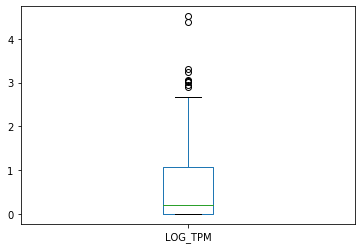

In [10]:
tpms.plot.box(y='LOG_TPM')

### Compute TAU, tissue specificity index (Yanai et al., 2004), for each gene.

> ## $ \tau = \frac{\sum_{i=0}^N (1 - x_i)}{N - 1} $

> * N = number of tissues
> * x = expression profile component normalized by the maximal component value

Validate with example vector from paper.  Should be 0.95.



In [11]:
def TAU(X):
  N = len(X)
  xmax = max(X)
  if xmax==0: return(0.0)
  tau = 0.0
  for x in X:
    tau += (1 - x/xmax)
  tau /= (N - 1)
  return(tau)
print('%.2f'%TAU([0,8,0,0,0,2,0,2,0,0,0,0]))

0.95


In [12]:
tpms_tau = tpms.groupby(['ENSG']).TPM.agg(TAU)
tpms_tau = pd.DataFrame(tpms_tau).rename(columns={'TPM':'TAU'})
tpms_tau = tpms_tau.reset_index(drop=False)
tpms_tau.head()

,ENSG,TAU
0,ENSG00000008130.15,0.611966
1,ENSG00000011007.12,0.374953
2,ENSG00000041988.15,0.412494
3,ENSG00000049246.14,0.786323
4,ENSG00000053371.12,0.472391


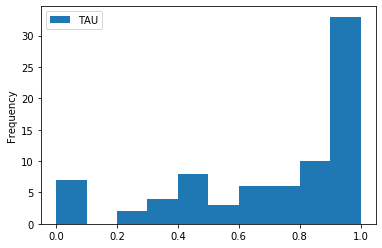

In [13]:
tpms_tau.plot.hist(y='TAU')

### Assign gene-tissue rank (quantile) among tissues.
Low-Med-High cutoff quantiles: .25 and .75.  These ranks measure, for a given gene, relative tissue expression from the gene-tissue TPMs.

In [14]:
def GTRanks(tpms, tpm_col):
  tpm_rank = pd.Series(dtype="float", index=range(tpms.shape[0]))
  for i in tpms.index:
    ensg = tpms.ENSG[i]
    val_this = tpms[tpm_col][i]
    vals_ensg = tpms[tpm_col][tpms.ENSG==ensg]
    vals_ensg = vals_ensg.sort_values().reset_index(drop=True)
    j = vals_ensg[vals_ensg == val_this].index[0]
    tpm_rank.iloc[i] = j/vals_ensg.size 

  tpms[tpm_col+'_RANK'] = tpm_rank
  return(tpms)

In [15]:
tpms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4712 entries, 0 to 4711
Data columns (total 7 columns):
ENSG       4712 non-null object
SMTSD      4712 non-null object
SEX        4712 non-null object
TPM        4712 non-null float64
NCBI       4712 non-null object
HGNC       4712 non-null object
LOG_TPM    4712 non-null float64
dtypes: float64(2), object(5)
memory usage: 294.5+ KB


In [16]:
t0 = time.time()
tpms_ranks = GTRanks(tpms.copy(), 'TPM')
print("Elapsed: %ds"%(time.time()-t0))
tpms_ranks.head()

Elapsed: 13s


,ENSG,SMTSD,SEX,TPM,NCBI,HGNC,LOG_TPM,TPM_RANK
0,ENSG00000008130.15,Adipose - Subcutaneous,female,63.265,65220,NADK,1.807975,0.900000
1,ENSG00000008130.15,Adipose - Subcutaneous,male,53.590,65220,NADK,1.737113,0.800000
2,ENSG00000008130.15,Adipose - Visceral (Omentum),female,58.310,65220,NADK,1.773128,0.883333
3,ENSG00000008130.15,Adipose - Visceral (Omentum),male,51.745,65220,NADK,1.722181,0.700000
4,ENSG00000008130.15,Adrenal Gland,female,67.880,65220,NADK,1.838093,0.933333


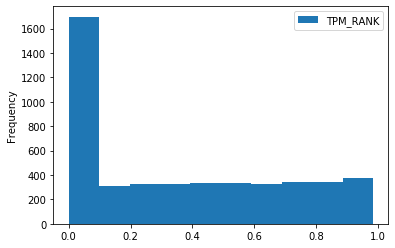

In [17]:
tpms_ranks.plot.hist(y='TPM_RANK')

In [18]:
tpms_ranks.describe()

,TPM,LOG_TPM,TPM_RANK
count,4712.000000,4712.000000,4712.000000
mean,26.146124,0.551512,0.356787
std,599.273257,0.654587,0.335785
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.585500,0.200166,0.300000
75%,11.125000,1.083682,0.650000
max,32670.000000,4.514162,0.983333


In [19]:
tpms_ranks['LEVEL'] = tpms_ranks.TPM_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
tpms_ranks['AGE'] = 'ALL'
tpms_ranks['SEX'] = 'ALL'
tpms_ranks.head()

,ENSG,SMTSD,SEX,TPM,NCBI,HGNC,LOG_TPM,TPM_RANK,LEVEL,AGE
0,ENSG00000008130.15,Adipose - Subcutaneous,ALL,63.265,65220,NADK,1.807975,0.900000,High,ALL
1,ENSG00000008130.15,Adipose - Subcutaneous,ALL,53.590,65220,NADK,1.737113,0.800000,High,ALL
2,ENSG00000008130.15,Adipose - Visceral (Omentum),ALL,58.310,65220,NADK,1.773128,0.883333,High,ALL
3,ENSG00000008130.15,Adipose - Visceral (Omentum),ALL,51.745,65220,NADK,1.722181,0.700000,Medium,ALL
4,ENSG00000008130.15,Adrenal Gland,ALL,67.880,65220,NADK,1.838093,0.933333,High,ALL


In [20]:
tpms_ranks.LEVEL.value_counts().sort_index()

High             893
Low              723
Medium          1645
Not detected    1451
Name: LEVEL, dtype: int64

### Compute TAU for each gene, stratified by sex:

In [21]:
tpms_tau_f = tpms.loc[tpms.SEX=='female'].groupby(['ENSG']).TPM.agg(TAU)
tpms_tau_f = pd.DataFrame(tpms_tau_f).rename(columns={'TPM':'TAU_F'})
tpms_tau_f.head()

,TAU_F
ENSG,
ENSG00000008130.15,0.578823
ENSG00000011007.12,0.370597
ENSG00000041988.15,0.390444
ENSG00000049246.14,0.787397
ENSG00000053371.12,0.478906


In [23]:
tpms_tau_m = tpms.loc[tpms.SEX=='male'].groupby(['ENSG']).TPM.agg(TAU)
tpms_tau_m = pd.DataFrame(tpms_tau_m).rename(columns={'TPM':'TAU_M'})
tpms_tau_m.head()

,TAU_M
ENSG,
ENSG00000008130.15,0.629630
ENSG00000011007.12,0.389029
ENSG00000041988.15,0.414001
ENSG00000049246.14,0.793303
ENSG00000053371.12,0.474038


In [27]:
tpms_tau = pd.merge(tpms_tau_f, tpms_tau_m, left_index=True, right_index=True)
tpms_tau = tpms_tau.reset_index(drop=False)
tpms_tau.head()

,ENSG,TAU_F,TAU_M
0,ENSG00000039139.9,0.881320,0.866073
1,ENSG00000082516.8,0.412861,0.470625
2,ENSG00000100302.6,0.857392,0.862967
3,ENSG00000100580.7,0.609194,0.610741
4,ENSG00000101200.5,0.899435,0.937310


### Combine rows into one row per gene+tissue, cols for M and F TPM.

In [24]:
tpms_f = tpms.loc[tpms['SEX'] == 'female']
tpms_f = tpms_f[['ENSG', 'SMTSD', 'TPM']].rename(columns={'TPM':'TPM_F'})
tpms_m = tpms.loc[tpms['SEX'] == 'male']
tpms_m = tpms_m[['ENSG', 'SMTSD', 'TPM']].rename(columns={'TPM':'TPM_M'})
tpms_sex = pd.merge(tpms_f, tpms_m, how='inner', on=['ENSG','SMTSD'])
tpms_sex.head()

,ENSG,SMTSD,TPM_F,TPM_M
0,ENSG00000008130.15,Adipose - Subcutaneous,63.265,53.590
1,ENSG00000008130.15,Adipose - Visceral (Omentum),58.310,51.745
2,ENSG00000008130.15,Adrenal Gland,67.880,70.475
3,ENSG00000008130.15,Artery - Aorta,52.910,52.490
4,ENSG00000008130.15,Artery - Coronary,55.630,52.275


In [25]:
t0 = time.time()
tpms_ranks_f = GTRanks(tpms_sex[['ENSG','SMTSD','TPM_F']].copy(), 'TPM_F')
print("Elapsed: %ds"%(time.time()-t0))
tpms_ranks_f['LEVEL_F'] = tpms_ranks_f.TPM_F_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
tpms_ranks_f.head()

Elapsed: 6s


,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F
0,ENSG00000008130.15,Adipose - Subcutaneous,63.265,0.866667,High
1,ENSG00000008130.15,Adipose - Visceral (Omentum),58.310,0.833333,High
2,ENSG00000008130.15,Adrenal Gland,67.880,0.933333,High
3,ENSG00000008130.15,Artery - Aorta,52.910,0.700000,Medium
4,ENSG00000008130.15,Artery - Coronary,55.630,0.800000,High


In [26]:
t0 = time.time()
tpms_ranks_m = GTRanks(tpms_sex[['ENSG','SMTSD','TPM_M']].copy(), 'TPM_M')
print("Elapsed: %ds"%(time.time()-t0))
tpms_ranks_m['LEVEL_M'] = tpms_ranks_m.TPM_M_RANK.apply(lambda x: 'Not detected' if x==0 else 'Low' if x<.25 else 'Medium' if x<.75 else 'High')
tpms_ranks_m.head()

Elapsed: 6s


,ENSG,SMTSD,TPM_M,TPM_M_RANK,LEVEL_M
0,ENSG00000008130.15,Adipose - Subcutaneous,53.590,0.833333,High
1,ENSG00000008130.15,Adipose - Visceral (Omentum),51.745,0.700000,Medium
2,ENSG00000008130.15,Adrenal Gland,70.475,0.933333,High
3,ENSG00000008130.15,Artery - Aorta,52.490,0.766667,High
4,ENSG00000008130.15,Artery - Coronary,52.275,0.733333,Medium


In [27]:
tpms_ranks = pd.merge(tpms_ranks_f, tpms_ranks_m, on=['ENSG','SMTSD'], how='inner')
tpms_ranks.head()

,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M
0,ENSG00000008130.15,Adipose - Subcutaneous,63.265,0.866667,High,53.590,0.833333,High
1,ENSG00000008130.15,Adipose - Visceral (Omentum),58.310,0.833333,High,51.745,0.700000,Medium
2,ENSG00000008130.15,Adrenal Gland,67.880,0.933333,High,70.475,0.933333,High
3,ENSG00000008130.15,Artery - Aorta,52.910,0.700000,Medium,52.490,0.766667,High
4,ENSG00000008130.15,Artery - Coronary,55.630,0.800000,High,52.275,0.733333,Medium


### Log fold-change is log of ratio.

In [28]:
tpms_ranks['log2foldchange'] = ((tpms_ranks.TPM_F+1) / (tpms_ranks.TPM_M+1)).apply(numpy.log2)
tpms_ranks['log2foldchange_abs'] = tpms_ranks.log2foldchange.apply(numpy.abs)
tpms_ranks.head()

,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M,log2foldchange,log2foldchange_abs
0,ENSG00000008130.15,Adipose - Subcutaneous,63.265,0.866667,High,53.590,0.833333,High,0.235397,0.235397
1,ENSG00000008130.15,Adipose - Visceral (Omentum),58.310,0.833333,High,51.745,0.700000,Medium,0.169241,0.169241
2,ENSG00000008130.15,Adrenal Gland,67.880,0.933333,High,70.475,0.933333,High,-0.053354,0.053354
3,ENSG00000008130.15,Artery - Aorta,52.910,0.700000,Medium,52.490,0.766667,High,0.011284,0.011284
4,ENSG00000008130.15,Artery - Coronary,55.630,0.800000,High,52.275,0.733333,Medium,0.088108,0.088108


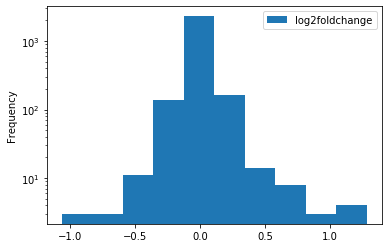

In [29]:
tpms_ranks.plot.hist(y='log2foldchange', logy=True)

### For selected tissue, sort genes by sex-difference magnitude:

In [30]:
tpms_bladder = tpms_ranks[tpms_ranks.SMTSD=="Bladder"]
tpms_bladder = tpms_bladder.sort_values(by=["log2foldchange_abs"], ascending=False)
tpms_bladder.drop(columns=['log2foldchange_abs'], inplace=True)
tpms_bladder = pd.merge(tpms_bladder, genes, on="ENSG", how="left")
tpms_bladder = tpms_bladder.reset_index(drop=True)
tpms_bladder.head(10)


,ENSG,SMTSD,TPM_F,TPM_F_RANK,LEVEL_F,TPM_M,TPM_M_RANK,LEVEL_M,log2foldchange,NCBI,HGNC
0,ENSG00000134668.12,Bladder,5.712,0.933333,High,13.030,0.966667,High,-1.063700,90853,SPOCD1
1,ENSG00000179546.4,Bladder,0.140,0.800000,High,1.302,0.933333,High,-1.013854,3352,HTR1D
2,ENSG00000158816.15,Bladder,1.028,0.900000,High,2.858,0.933333,High,-0.927795,127731,VWA5B1
3,ENSG00000175206.10,Bladder,2.696,0.333333,Medium,1.233,0.033333,Low,0.726982,4878,NPPA
4,ENSG00000142619.4,Bladder,58.002,0.966667,High,90.835,0.966667,High,-0.638280,51702,PADI3
5,ENSG00000173641.17,Bladder,56.205,0.566667,Medium,75.040,0.566667,Medium,-0.410617,27129,HSPB7
6,ENSG00000142794.18,Bladder,4.820,0.966667,High,6.544,0.966667,High,-0.374311,84224,NBPF3
7,ENSG00000169641.13,Bladder,11.740,0.500000,Medium,15.480,0.900000,High,-0.371351,7798,LUZP1
8,ENSG00000076864.19,Bladder,9.746,0.500000,Medium,12.515,0.500000,Medium,-0.330762,5909,RAP1GAP
9,ENSG00000133216.16,Bladder,1.566,0.666667,Medium,2.220,0.800000,High,-0.327540,2048,EPHB2


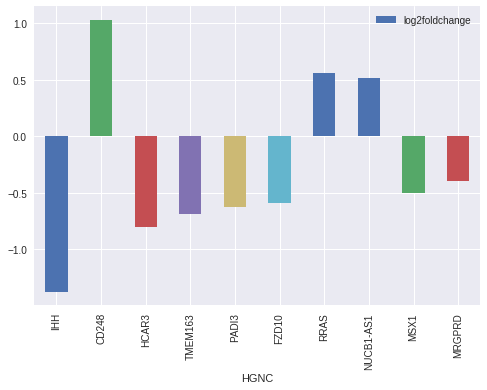

In [40]:
plotdata = tpms_bladder.iloc[0:10]
plotdata.plot.bar(y='log2foldchange', x='HGNC')

### For each gene, compute sex difference via Wilcoxon signed-rank test:
(Wilcoxon signed-rank test, with Wilcox treatment, discarding all zero-differences.)

In [33]:
results = pd.DataFrame({'ENSG':tpms_sex.ENSG.drop_duplicates().sort_values(), 'WilcoxonSignedRank_stat':None, 'WilcoxonSignedRank_pval':None}).reset_index(drop=True)

for i in range(results.shape[0]):
  tpm_f_this = tpms_sex.TPM_F[tpms_ranks.ENSG==results.ENSG[i]]
  tpm_m_this = tpms_sex.TPM_M[tpms_ranks.ENSG==results.ENSG[i]]
  # Sample size must be sufficient.
  if tpm_f_this[tpm_f_this>0].size<8 or tpm_m_this[tpm_m_this>0].size<8:
    continue
  stat, pval = scipy.stats.wilcoxon(x=tpm_f_this, y=tpm_m_this, zero_method='wilcox')
  results.WilcoxonSignedRank_stat.iloc[i] = stat
  results.WilcoxonSignedRank_pval.iloc[i] = pval 
results.head()

,ENSG,WilcoxonSignedRank_stat,WilcoxonSignedRank_pval
0,ENSG00000008130.15,164,0.158855
1,ENSG00000011007.12,105,0.00872789
2,ENSG00000041988.15,120,0.0206711
3,ENSG00000049246.14,103,0.00773094
4,ENSG00000053371.12,204,0.557743
